# Fitting a segment of the light curve of Kepler-289 with Sequential Monte Carlo via PyMC3

First let's download the light curve using `lightkurve`:

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from lightkurve import search_lightcurvefile

lcf = search_lightcurvefile('Kepler-289', mission='Kepler').download_all()
lc = lcf.stitch()

//anaconda3/lib/python3.7/site-packages/lightkurve/collections.py:212: LightkurveWarning: Stitching a `LightCurveFileCollection` which contains both SAP and PDCSAP_FLUX. Plotting PDCSAP_FLUX. You can remove this warning by using `LightCurveFileCollection.PDCSAP_FLUX.stitch()`.
  LightkurveWarning)


In [5]:
t, f, e = lc.time[~np.isnan(lc.flux)], lc.flux[~np.isnan(lc.flux)], lc.flux_err[~np.isnan(lc.flux)]

(1000.0, 1190.0)

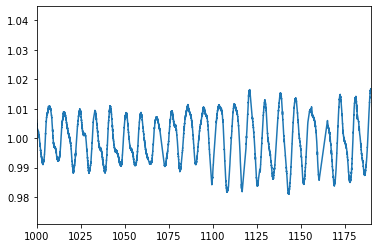

In [11]:
plt.plot(t, f)
plt.xlim([1000, 1190])
# plt.ylim([0.997, 1.003])

Next let's extract just a segment of the light curve that's quasiperiodic:

In [73]:
# max_time = 1090
# min_time = 1000
max_time = 1060
min_time = 1030
skip = 5

t1, f1, e1 = t[(t < max_time) & (t > min_time)][::skip], f[(t < max_time) & (t > min_time)][::skip], e[(t < max_time) & (t > min_time)][::skip]

<ErrorbarContainer object of 3 artists>

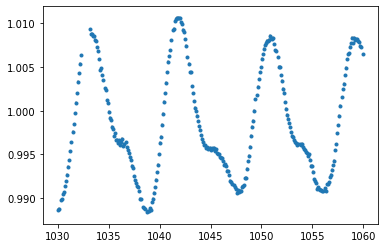

In [74]:
plt.errorbar(t1, f1, e1, fmt='.', ecolor='silver')

We'll implement the model in numpy first, so we can visualize things later: 

In [75]:
def numpy_model_seq(lat, lon, rspot, f0, per, shear, contrast=0.7):
    
    spot_model = 1 + f0
    eq_period = per

    for i in range(len(lon)):
        period_i = eq_period / (1 - shear * np.sin(np.pi/2 - lat[i])**2)
        spot_position_y = (np.pi/2 - lat[i]) / (np.pi / 2)
        spot_position_x = np.sqrt(1 - spot_position_y**2) * np.cos(2 * np.pi / period_i * (t1 - t1.mean()) - lon[i])
        spot_position_z = np.sqrt(1 - spot_position_y**2) * np.sin(2 * np.pi / period_i * (t1 - t1.mean()) - lon[i])
        rsq = spot_position_x**2 + spot_position_y**2
        spot_model -= rspot[i]**2 * (1 - contrast) * np.where(spot_position_z > 0, np.sqrt(1 - rsq), 0)
    return spot_model

In [76]:
m = numpy_model_seq([0.5, 1.5], [0, np.pi], [0.2, 0.2], 0.001, 9, 0.2)
# m = numpy_model_seq([1.5], [np.pi], [0.05], 0.001, 26, 0.2)

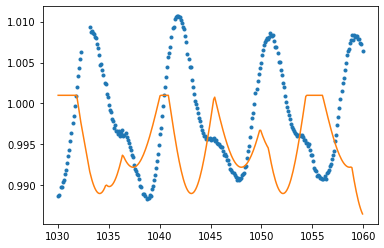

In [77]:
plt.plot(t1, f1, '.')
plt.plot(t1, m)

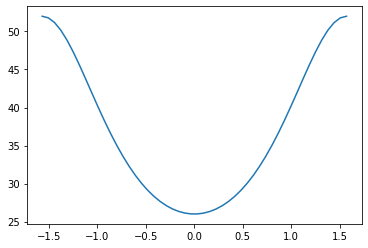

In [78]:
x = np.linspace(0, np.pi) - np.pi/2
shear = 0.5
plt.plot(x, 26 / (1 - shear * np.sin(x)**2))

Implement the same model with PyMC3 assuming: 

* there are 3 spots
* the lat, lon, radius of spots are allowed to vary
* contrast = 0.7
* flux residuals are Student t-distributed (robust against outliers)
* spot radii are small compared to stellar radius
* spots don't evolve significantly over this timescale

In [79]:
import pymc3 as pm
from pymc3.smc import sample_smc
import theano
from corner import corner


e1_tt = theano.shared(np.asarray(e1, dtype=theano.config.floatX), name='e1')

In [92]:
n_spots = 4

with pm.Model() as model1:

    f0 = pm.Uniform("f0", lower=0, upper=1)
    nu = pm.Uniform("nu", lower=1, upper=5)    
    #slope = pm.Uniform("m", lower=-1, upper=1)
    spot_model = 1 + f0 #+ slope * (t1 - t1.mean())
    eq_period = pm.Uniform("P_eq", lower=5, upper=15)
    shear = pm.Uniform("shear", lower=0.05, upper=0.6)
    
    for spot_ind in range(n_spots):
        rspot = pm.Uniform(f"R_spot_{spot_ind}", lower=0.01, upper=0.3)
        lon = pm.Uniform(f"lon_{spot_ind}", lower=0, upper=2*np.pi)
        latitude_cutoff = 10
        lat = pm.Uniform(f"lat_{spot_ind}", lower=np.radians(latitude_cutoff), upper=np.radians(180-latitude_cutoff))
        period = eq_period / (1 - shear * pm.math.sin(lat - np.pi/2)**2)

        spot_position_y = (np.pi/2 - lat) / (np.pi / 2)
        spot_position_x = pm.math.sqrt(1 - spot_position_y**2) * pm.math.cos(2 * np.pi / period * (t1 - t1.mean()) - lon)
        spot_position_z = pm.math.sqrt(1 - spot_position_y**2) * pm.math.sin(2 * np.pi / period * (t1 - t1.mean()) - lon)
        rsq = spot_position_x**2 + spot_position_y**2
        contrast = 0.7
        spot_model -= rspot**2 * (1 - contrast) * pm.math.where(spot_position_z > 0, pm.math.sqrt(1 - rsq), 0)
    
    pm.StudentT("obs", mu=spot_model, nu=nu,
                sigma=e1_tt,
                observed=f1)
    
    trace1 = sample_smc(10000, n_steps=2, random_seed=0, 
                        cores=16, parallel=True, threshold=0.2)

Sample initial stage: ...
INFO:pymc3:Sample initial stage: ...
Stage:   0 Beta: 0.001 Steps:   2 Acce: 1.000
INFO:pymc3:Stage:   0 Beta: 0.001 Steps:   2 Acce: 1.000
Stage:   1 Beta: 0.002 Steps:   2 Acce: 0.464
INFO:pymc3:Stage:   1 Beta: 0.002 Steps:   2 Acce: 0.464
Stage:   2 Beta: 0.006 Steps:   2 Acce: 0.333
INFO:pymc3:Stage:   2 Beta: 0.006 Steps:   2 Acce: 0.333
Stage:   3 Beta: 0.013 Steps:   2 Acce: 0.242
INFO:pymc3:Stage:   3 Beta: 0.013 Steps:   2 Acce: 0.242
Stage:   4 Beta: 0.024 Steps:   2 Acce: 0.162
INFO:pymc3:Stage:   4 Beta: 0.024 Steps:   2 Acce: 0.162
Stage:   5 Beta: 0.033 Steps:   2 Acce: 0.102
INFO:pymc3:Stage:   5 Beta: 0.033 Steps:   2 Acce: 0.102
Stage:   6 Beta: 0.043 Steps:   2 Acce: 0.080
INFO:pymc3:Stage:   6 Beta: 0.043 Steps:   2 Acce: 0.080
Stage:   7 Beta: 0.065 Steps:   2 Acce: 0.091
INFO:pymc3:Stage:   7 Beta: 0.065 Steps:   2 Acce: 0.091
Stage:   8 Beta: 0.095 Steps:   2 Acce: 0.075
INFO:pymc3:Stage:   8 Beta: 0.095 Steps:   2 Acce: 0.075
Stage:   9

Make a corner plot showing the posterior distributions for each parameter: 

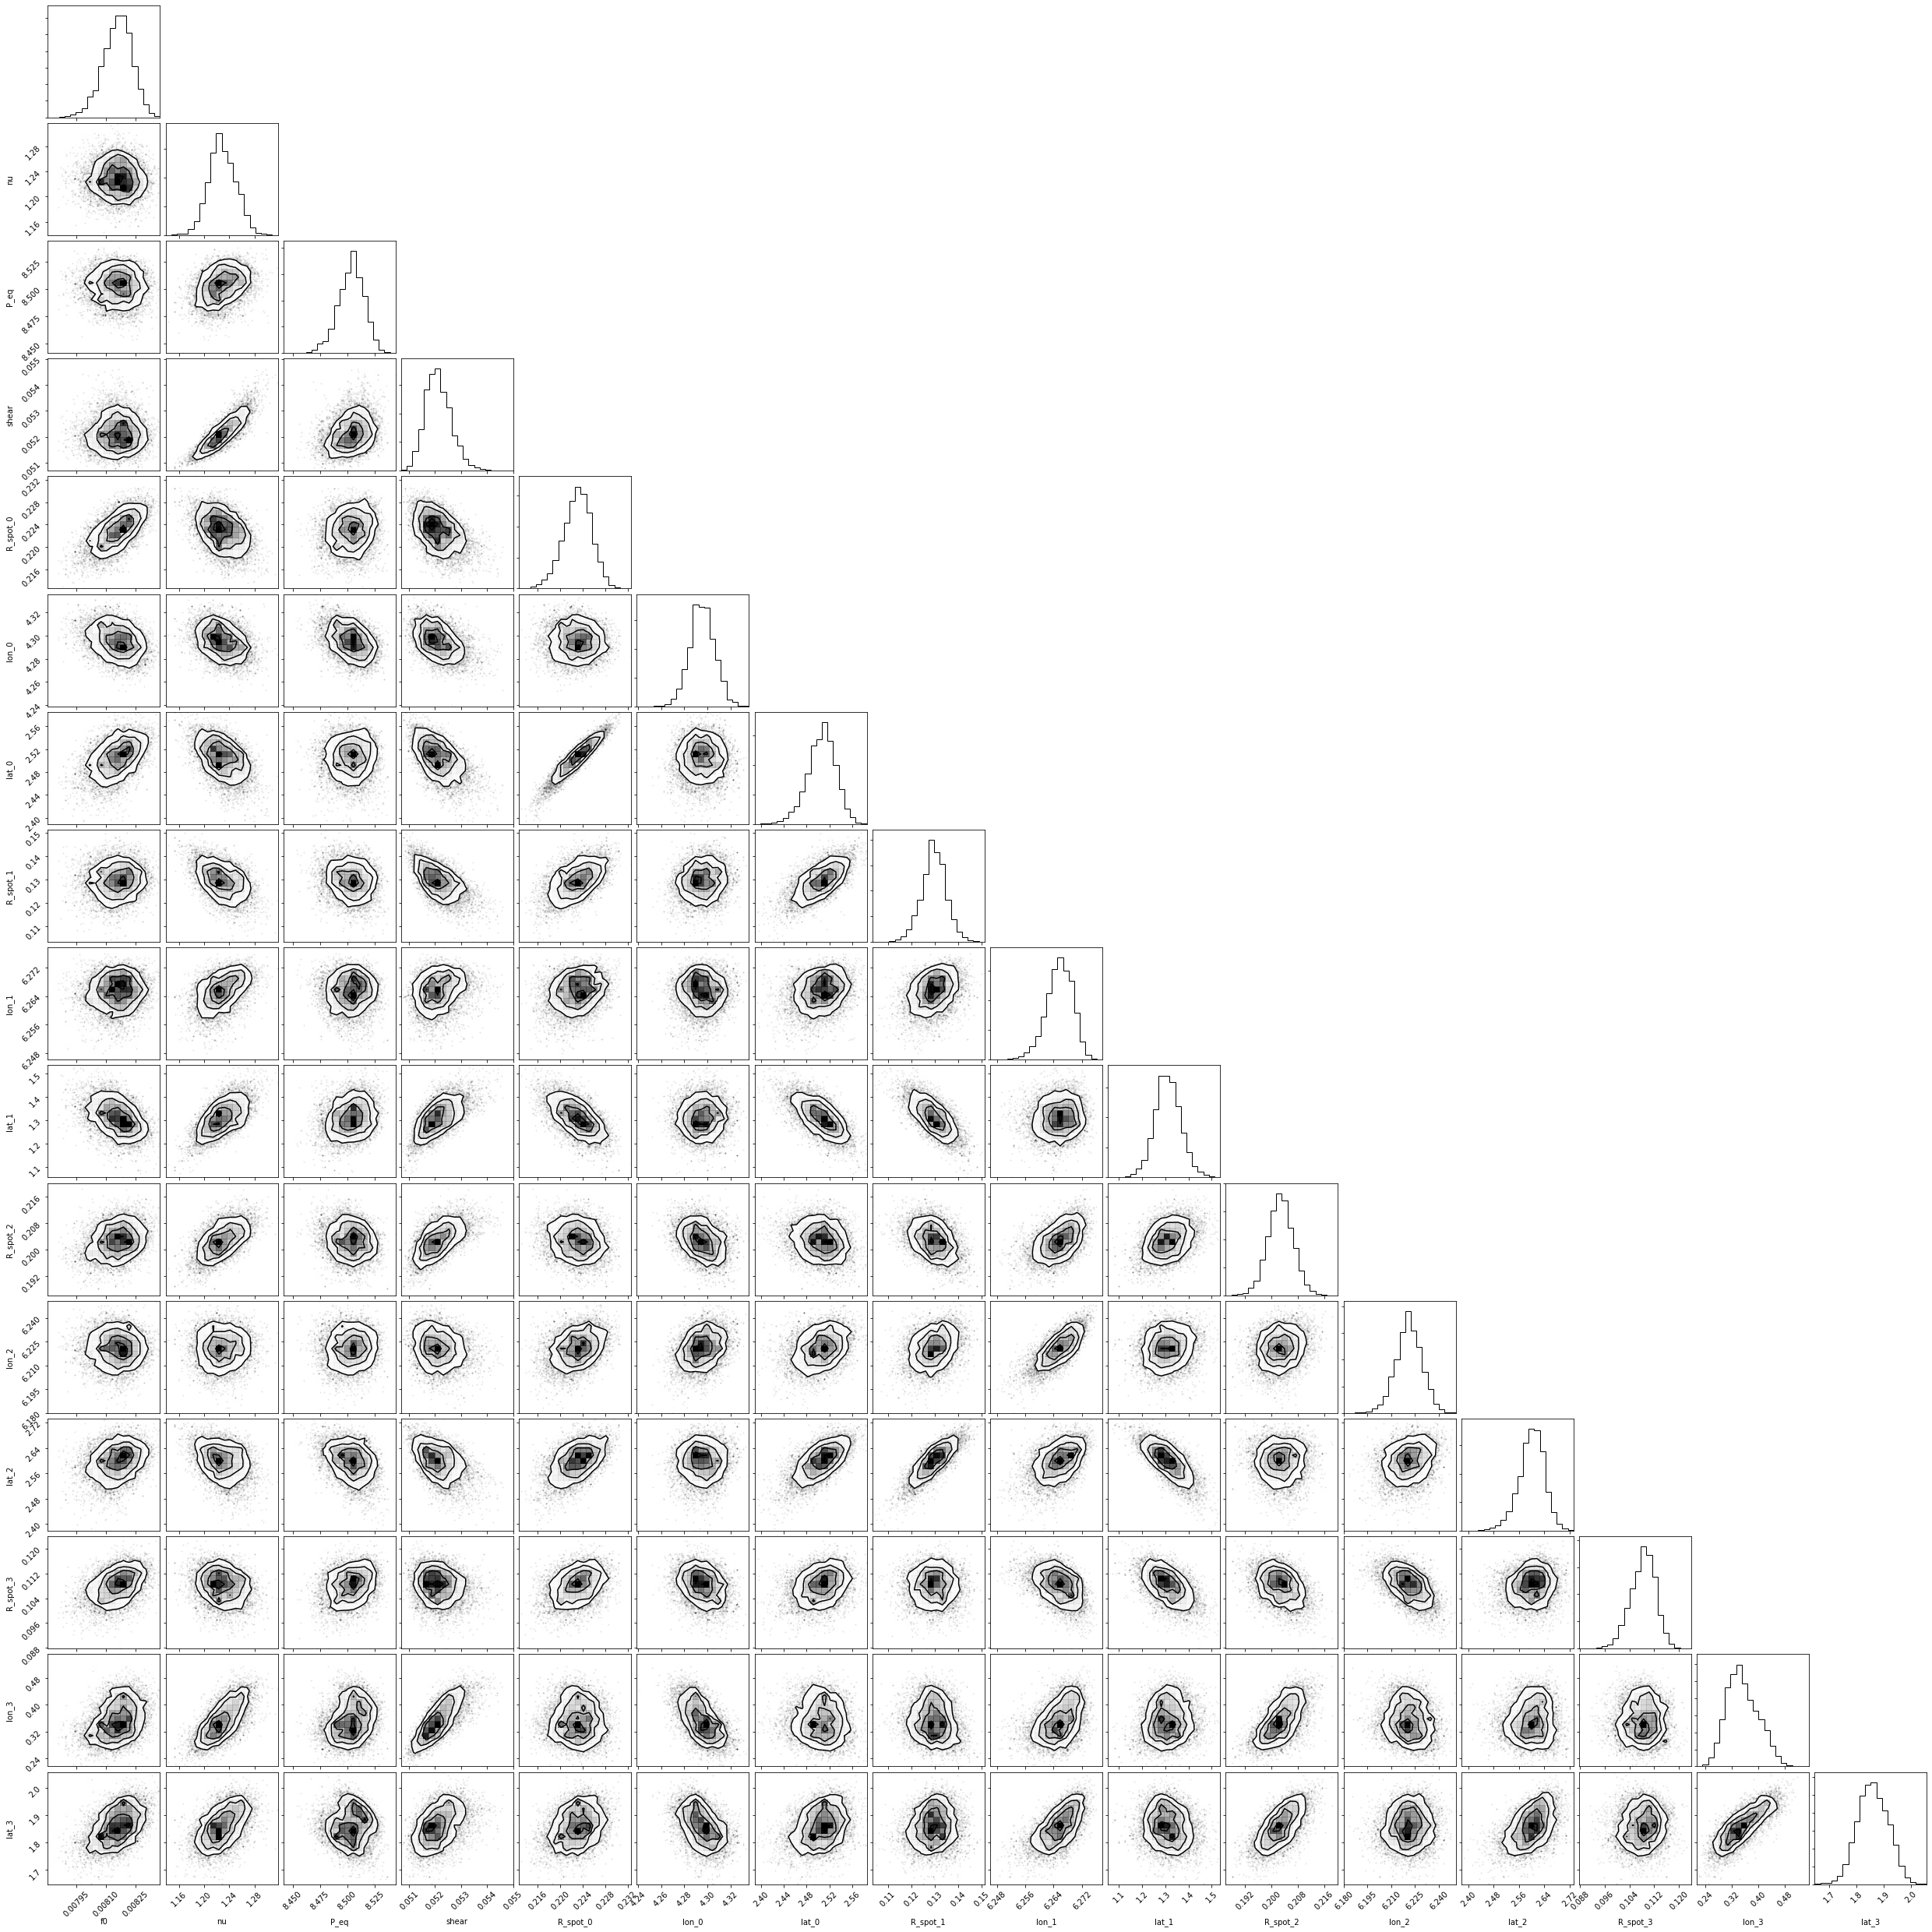

In [93]:

corner(pm.trace_to_dataframe(trace1));
# plt.savefig('plots/corner_dr.png', bbox_inches='tight', dpi=100)

Plot the model evaluated at samples from the posterior distributions:

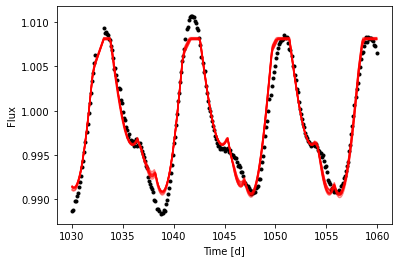

In [94]:
samples = pm.trace_to_dataframe(trace1).values
plt.plot(t1, f1, '.', color='k')

for s in samples[np.random.randint(0, samples.shape[0], size=10)]:
    f0, per, shear, rspot, lon, lat = s[0], s[2], s[3], s[4::3], s[5::3], s[6::3]
    plt.plot(t1, numpy_model_seq(lat, lon, rspot, f0, per, shear), color='r', alpha=0.5)
    
plt.gca().set(xlabel='Time [d]', ylabel='Flux')
# plt.savefig('plots/')
plt.show()

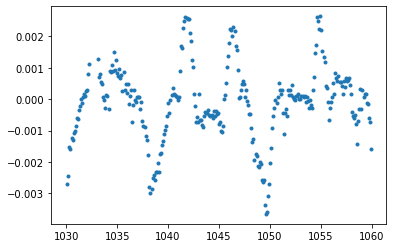

In [95]:
plt.plot(t1, f1 - numpy_model_seq(lat, lon, rspot, f0, per, shear), '.')

(array([1.080e+02, 1.057e+03, 3.100e+03, 3.153e+03, 1.715e+03, 6.430e+02,
        1.580e+02, 5.000e+01, 1.400e+01, 2.000e+00]),
 array([0.05069532, 0.05112691, 0.0515585 , 0.05199008, 0.05242167,
        0.05285326, 0.05328484, 0.05371643, 0.05414802, 0.0545796 ,
        0.05501119]),
 <a list of 10 Patch objects>)

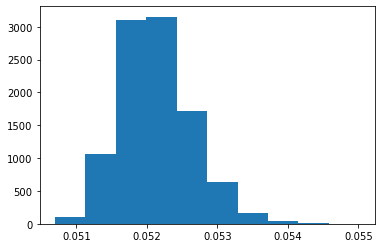

In [96]:
plt.hist(samples[:, 3])

4.295161857598641 2.507316324398758
6.265742888985297 1.3084540995111018
6.220871497458148 2.6011046035998384
0.3468626698026307 1.858177199461405
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


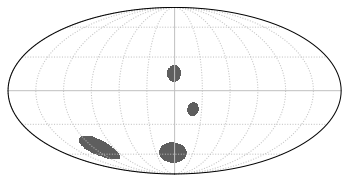

In [97]:
import healpy as hp

NSIDE = 2**10

NPIX = hp.nside2npix(NSIDE)

m = np.zeros(NPIX)

samples = pm.trace_to_dataframe(trace1).values

for rspot, lon, lat in np.median(samples[:, 4:], axis=0).reshape((n_spots, 3)):
    print(lon, lat)
    spot_vec = hp.ang2vec(lat, lon)
    ipix_spots = hp.query_disc(nside=NSIDE, vec=spot_vec, radius=rspot)
    m[ipix_spots] = 0.7

cmap = plt.cm.Greys
cmap.set_under('w')

hp.mollview(m, cbar=False, title="", cmap=cmap, hold=True,
            max=1.0, notext=True, flip='geo')
hp.graticule(color='silver')
plt.show()

In [98]:
models = []
traces = []

min_spots = 4
max_spots = 14

for n_spots in range(min_spots, max_spots + 1):
    with pm.Model(name=n_spots) as model:

        f0 = pm.Uniform("f0", lower=0, upper=1)
        nu = pm.Uniform("nu", lower=1, upper=5)    
        spot_model = 1 + f0 
        eq_period = pm.Uniform("P_eq", lower=5, upper=10)
        shear = pm.Uniform("shear", lower=0.01, upper=0.6)

        for spot_ind in range(n_spots):
            rspot = pm.Uniform(f"R_spot_{spot_ind}", lower=0.001, upper=0.4)
            lon = pm.Uniform(f"lon_{spot_ind}", lower=0, upper=2*np.pi)
            lat = pm.Uniform(f"lat_{spot_ind}", lower=0, upper=np.pi)
            period = eq_period / (1 - shear * pm.math.sin(lat - np.pi/2)**2)

            spot_position_y = (np.pi/2 - lat) / (np.pi / 2)
            spot_position_x = pm.math.sqrt(1 - spot_position_y**2) * pm.math.cos(2 * np.pi / period * (t1 - t1.mean()) - lon)
            spot_position_z = pm.math.sqrt(1 - spot_position_y**2) * pm.math.sin(2 * np.pi / period * (t1 - t1.mean()) - lon)
            rsq = spot_position_x**2 + spot_position_y**2
            contrast = 0.7
            spot_model -= rspot**2 * (1 - contrast) * pm.math.where(spot_position_z > 0, pm.math.sqrt(1 - rsq), 0)

        pm.StudentT("obs", mu=spot_model, nu=nu,
                    sigma=e1_tt,
                    observed=f1)

        trace = sample_smc(50000, n_steps=2, random_seed=0, threshold=0.2,
                           cores=16, parallel=True)

#     corner(pm.trace_to_dataframe(trace));
#     plt.show()
    
    models.append(model)
    traces.append(trace)

Sample initial stage: ...
INFO:pymc3:Sample initial stage: ...
Stage:   0 Beta: 0.001 Steps:   2 Acce: 1.000
INFO:pymc3:Stage:   0 Beta: 0.001 Steps:   2 Acce: 1.000
Stage:   1 Beta: 0.002 Steps:   2 Acce: 0.460
INFO:pymc3:Stage:   1 Beta: 0.002 Steps:   2 Acce: 0.460
Stage:   2 Beta: 0.007 Steps:   2 Acce: 0.335
INFO:pymc3:Stage:   2 Beta: 0.007 Steps:   2 Acce: 0.335
Stage:   3 Beta: 0.013 Steps:   2 Acce: 0.234
INFO:pymc3:Stage:   3 Beta: 0.013 Steps:   2 Acce: 0.234
Stage:   4 Beta: 0.020 Steps:   2 Acce: 0.131
INFO:pymc3:Stage:   4 Beta: 0.020 Steps:   2 Acce: 0.131
Stage:   5 Beta: 0.029 Steps:   2 Acce: 0.061
INFO:pymc3:Stage:   5 Beta: 0.029 Steps:   2 Acce: 0.061
Stage:   6 Beta: 0.042 Steps:   2 Acce: 0.034
INFO:pymc3:Stage:   6 Beta: 0.042 Steps:   2 Acce: 0.034
Stage:   7 Beta: 0.054 Steps:   2 Acce: 0.024
INFO:pymc3:Stage:   7 Beta: 0.054 Steps:   2 Acce: 0.024
Stage:   8 Beta: 0.078 Steps:   2 Acce: 0.022
INFO:pymc3:Stage:   8 Beta: 0.078 Steps:   2 Acce: 0.022
Stage:   9

In [99]:
# models[0].name = str(models[0].name)
# models[1].name = str(models[1].name)

In [100]:
loo = pm.compare({m: t for m, t in zip(models, traces)})
loo.index = [m.name for m in loo.index.values]

loo

//anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:151: UserWarning: 
The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive accuracy.
  "\nThe scale is now log by default. Use 'scale' argument or "
//anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
//anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:683: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO post

rank      loo    p_loo    d_loo       weight       se      dse warning  \
6     0  1476.59  29.3695        0     0.489944  29.3376        0   False   
10    1  1475.08  45.8114  1.50815     0.416957   25.429  32.2297    True   
4     2  1450.25  28.7944  26.3347    0.0698789  29.7683  37.9183   False   
9     3  1445.92  45.2602  30.6634    0.0179535  27.2335  33.8652    True   
7     4  1427.81  83.9853    48.78  9.44068e-05  28.3093  34.0303   False   
8     5     1418  16.5343  58.5917   0.00474005  25.5276  34.0905   False   
5     6  1401.39  101.731   75.198  1.86207e-15  26.8916  18.6057    True   
12    7  1396.92  31.5243  79.6666  5.97414e-07  27.8668   31.888   False   
14    8   1389.9  59.9419  86.6845  1.37847e-12   26.745  35.5834    True   
11    9  1385.56   9.4433  91.0275  0.000431328  27.5934  34.7139   False   
13   10  1267.62  164.907  208.963  1.05352e-48  28.5346  41.8672    True   

   loo_scale  
6        log  
10       log  
4        log  
9        log  
7        log  
8        log  
5        log  
12       log  
14       log  
11       log  
13       log

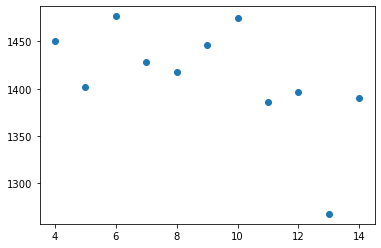

In [101]:
plt.plot(loo.index, loo.loo, 'o')

In [ ]:
# lats = samples[:, 5::4]

# plt.hist(lats)
# plt.errorbar(lats.mean(axis=0), pers.mean(axis=0), xerr=lats.std(axis=0), yerr=pers.std(axis=0), fmt='o')

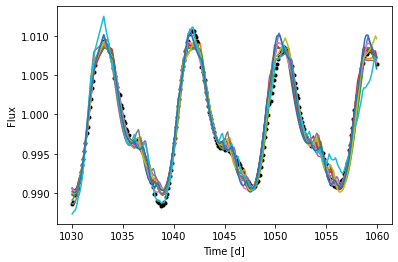

In [102]:
plt.plot(t1, f1, '.', color='k')

for i, trace in enumerate(traces): 
    samples = pm.trace_to_dataframe(trace).values

    for s in samples[np.random.randint(0, samples.shape[0], size=1)]:
        f0, per, shear, rspot, lon, lat = s[0], s[2], s[3], s[4::3], s[5::3], s[6::3]
        plt.plot(t1, numpy_model_seq(lat, lon, rspot, f0, per, shear), color=f'C{i}', alpha=1)

plt.gca().set(xlabel='Time [d]', ylabel='Flux')
plt.show()

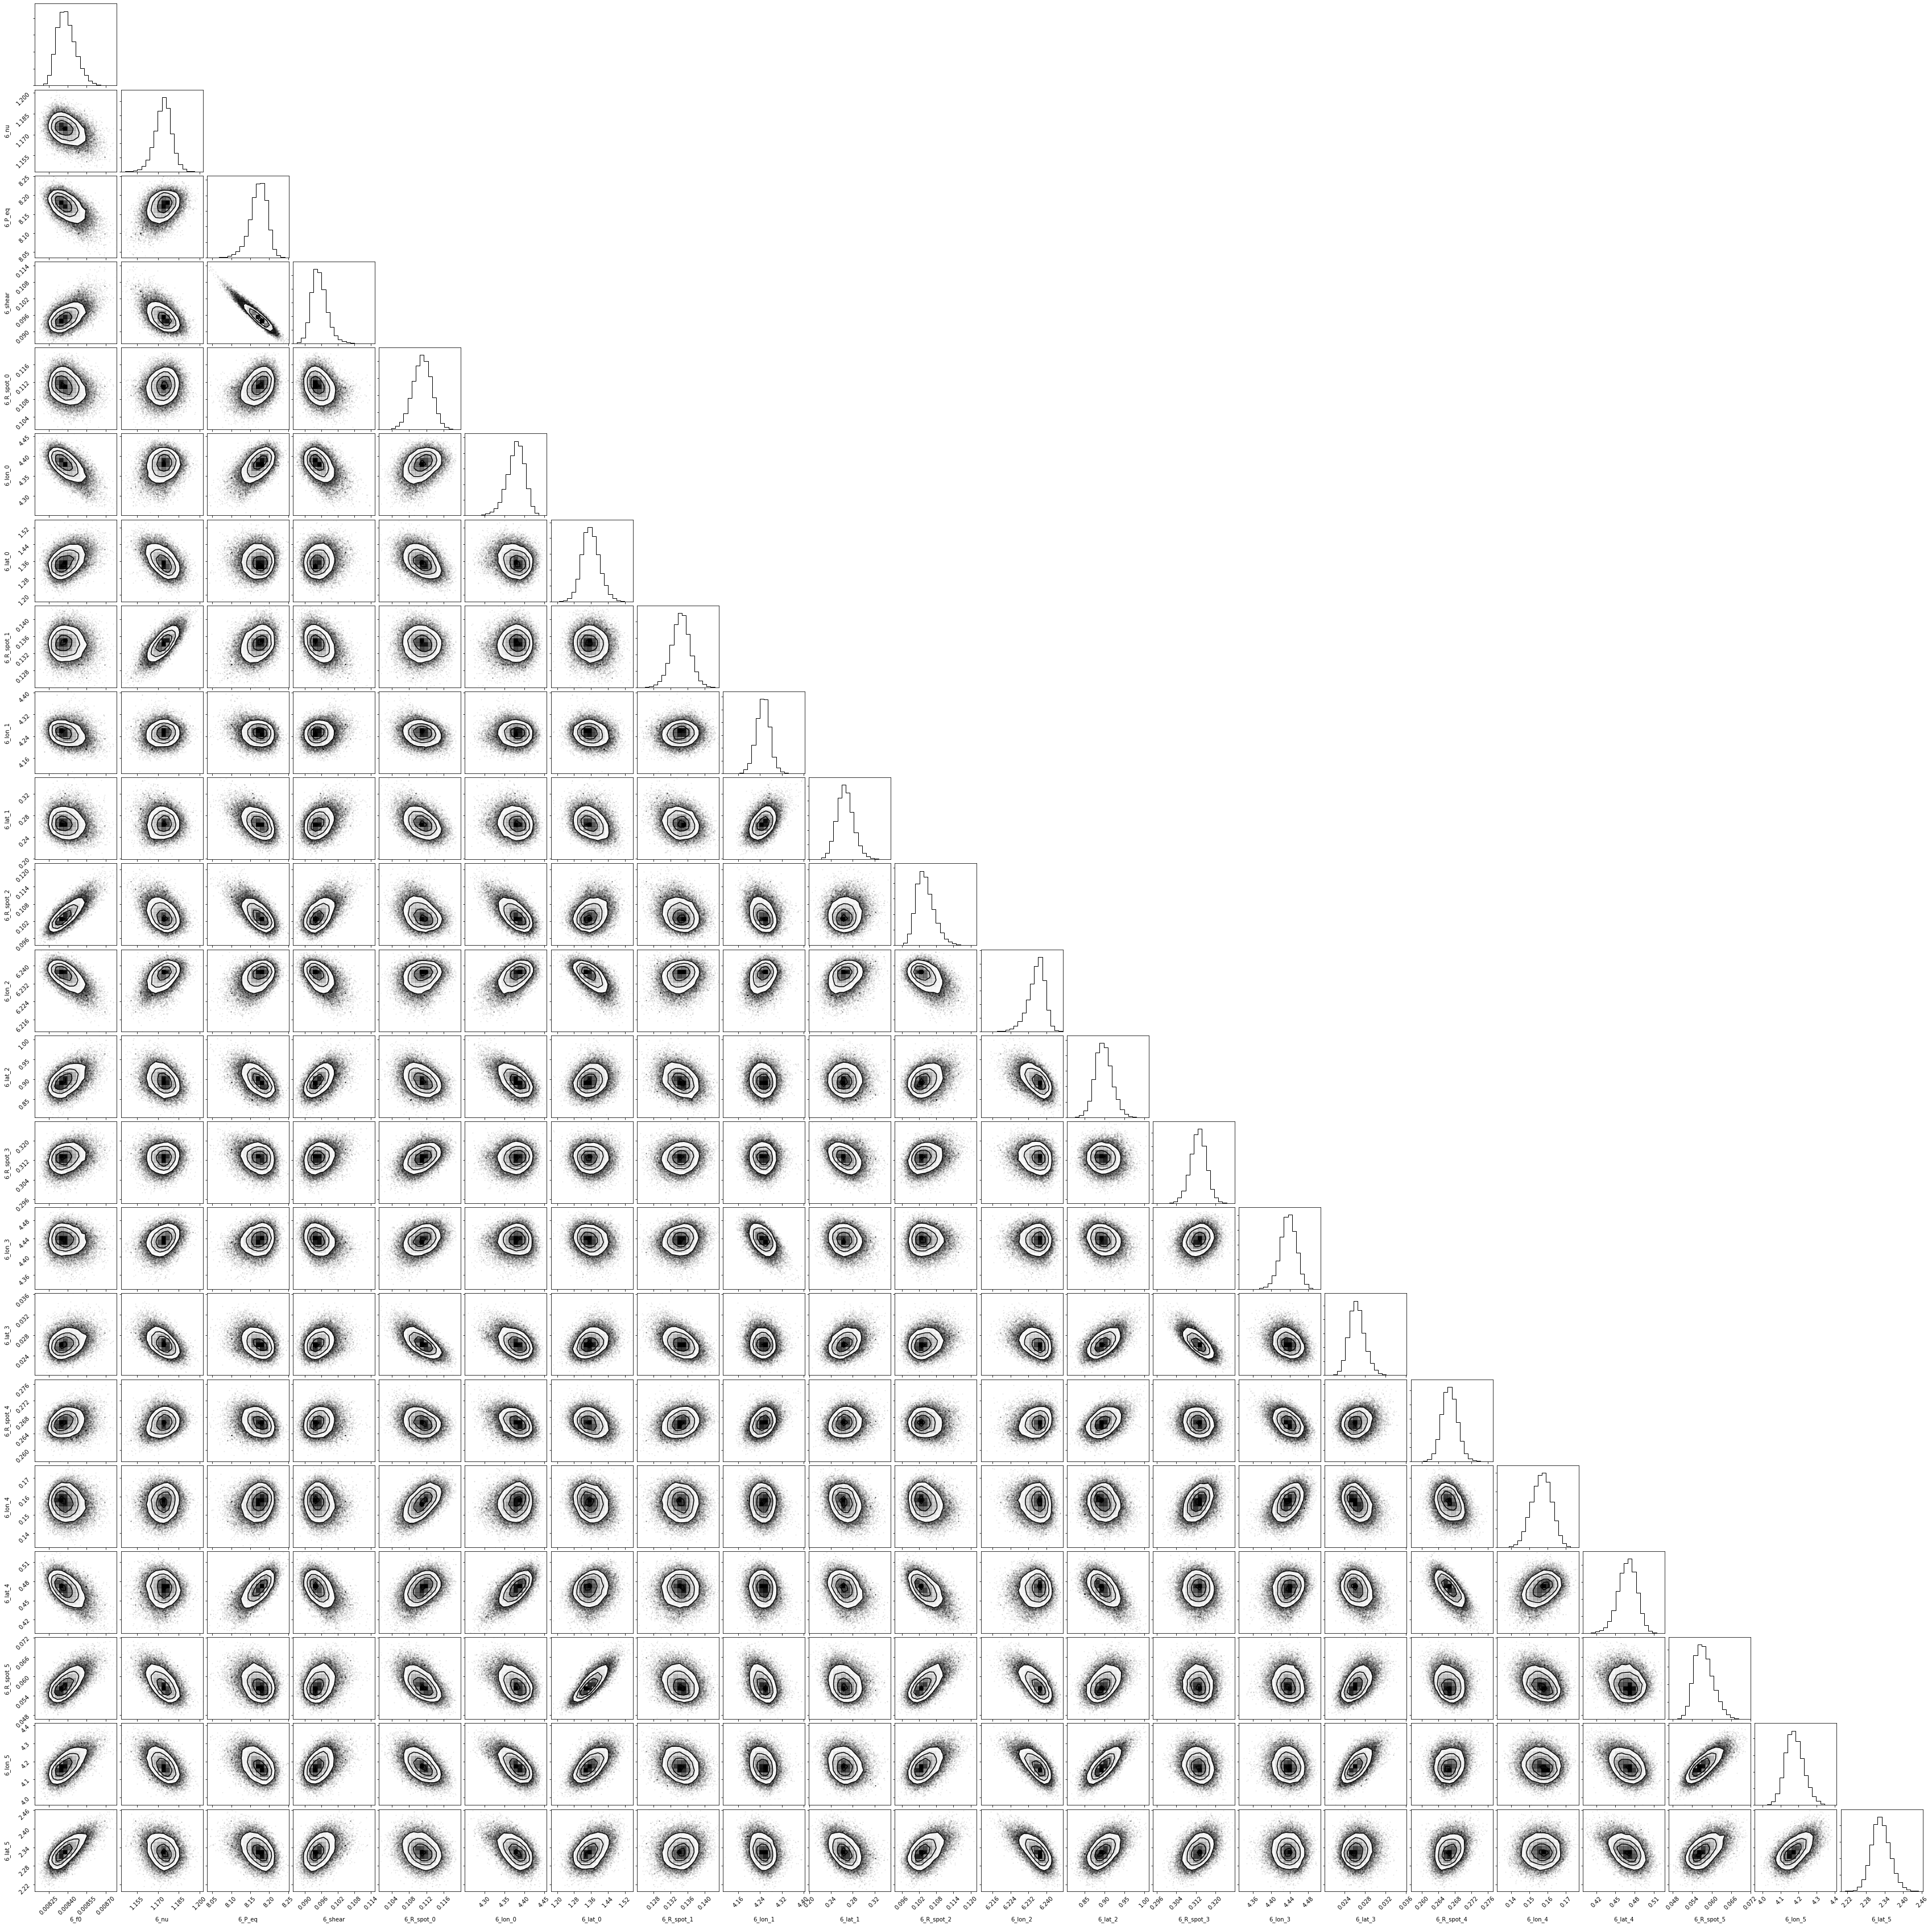

Text(0.5, 0, 'Shear')

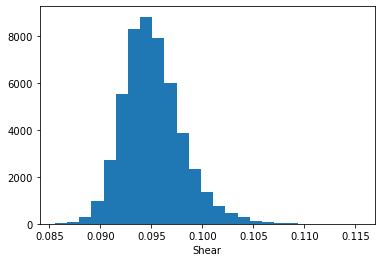

In [108]:
samples = pm.trace_to_dataframe(traces[2]).values

corner(samples, labels=[i for i in traces[2].varnames if not i.endswith('__')])
plt.show()

plt.hist(samples[:, 3], bins=25)
plt.xlabel('Shear')

In [104]:
# import healpy as hp

# NSIDE = 2**8

# NPIX = hp.nside2npix(NSIDE)

# for i, trace in enumerate(traces):
#     m = np.zeros(NPIX)

#     samples = pm.trace_to_dataframe(trace).values

#     for rspot, lon, lat in np.median(samples[:, 4:], axis=0).reshape((2*i + min_spots, 3)):
#         print(lon, lat)
#         spot_vec = hp.ang2vec(lat, lon)
#         ipix_spots = hp.query_disc(nside=NSIDE, vec=spot_vec, radius=rspot)
#         m[ipix_spots] = 0.7

#     cmap = plt.cm.Greys
#     cmap.set_under('w')

#     hp.mollview(m, cbar=False, title="", cmap=cmap, hold=True,
#                 max=1.0, notext=True, flip='geo')
#     hp.graticule(color='silver')
#     plt.show()

In [105]:
# np.median(samples[:, 4:], axis=0).reshape((6, 3))